In [120]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from scipy.interpolate import splrep, splev

In [2]:
def get_hyper_params(filename):
	hyper_params = {}
	if not os.path.exists(dir_path + filename):
		C_range = np.logspace(0, 4, 5)
		gamma_range = np.logspace(-10, -1, 10)
		param_grid = dict(gamma=gamma_range, C=C_range)
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
		grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv=cv)
		for i in range(y.shape[1]):
			grid.fit(X, y.iloc[:, i])
			hyper_params[i] = grid.best_params_
			# print("The best parameters are %s with a score of %0.2f"
			#       % (grid.best_params_, grid.best_score_))
		with open(dir_path + filename, 'wb') as file:
			pickle.dump(hyper_params, file, protocol=pickle.HIGHEST_PROTOCOL)
	else:
		hyper_params = None
		with open(dir_path + filename, 'rb') as file:
			hyper_params = pickle.load(file)
	return hyper_params

In [3]:
def compute_svm_error(hyper_params):
    result = []
    for i in range(y.shape[1]):
        errors = []
        y_1d = y.iloc[:, i]
        model = SVR(kernel='rbf', C=hyper_params[i]['C'], gamma=hyper_params[i]['gamma'])
        for j, row in X.iterrows():
            model.fit(X.drop(index=j), y_1d.drop(index=j))
            f_p = model.predict(X.iloc[j, :].values.reshape(1, -1)).flatten()
            f_t = [y.iloc[j, i]]
            e = np.abs(f_t - f_p)
            errors.append(e)
        errors = np.asarray(errors)
        avg_error = np.mean(errors, axis=0)
        result.append(avg_error)
    result = pd.DataFrame(data=result, index=attribute_names)
    semantic_result = result[result.index.isin(semantic_features)]
    print('Error: ' + str(semantic_result.mean().round(3).loc[0]))

In [254]:
def visualize_svm(hyper_params):
    for i in range(0, y.shape[1]):
        y_1d = y.iloc[:, i]
        model = SVR(kernel='rbf', C=hyper_params[i]['C'], gamma=hyper_params[i]['gamma'])
        model.fit(X, y_1d)
        X0, X1 = X_pca[:, 0], X_pca[:, 1]
        ax = plt.gca()
        ax.scatter(X0, X1, c=y_1d, cmap=plt.cm.viridis, s=20)
        ax.set_title(attribute_names[i])
        plt.show()

In [7]:
dir_path = 'data/'
fj_unlabeled_font_vectors = pd.read_pickle(dir_path + 'fj_ul_font_vectors.pkl')
fj_labeled_font_vectors = pd.read_pickle(dir_path + 'fj_l_font_vectors.pkl')
common_attribute_labels = pd.read_pickle(dir_path + 'common_attribute_labels.pkl')

attribute_names = np.loadtxt(dir_path + 'attrNames.txt', dtype=str)
typographic_features = np.asarray(['font_name', 'capitals', 'cursive', 'display', 'italic', 'monospace', 'serif'])
semantic_features = attribute_names[~np.isin(attribute_names, typographic_features)]

In [8]:
X = fj_labeled_font_vectors.iloc[:, 1:]
y = common_attribute_labels.iloc[:, 1:]

In [9]:
hyper_params = get_hyper_params('hyper_params.pkl')
compute_svm_error(hyper_params)

Error: 0.079


In [227]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

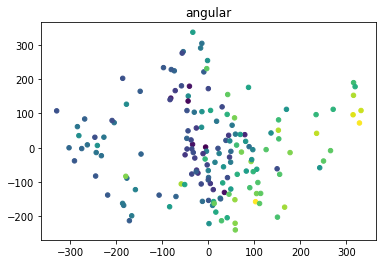

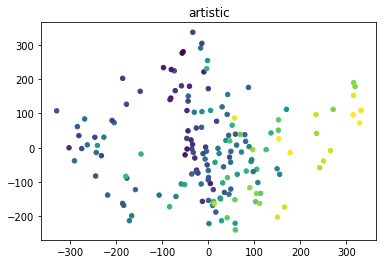

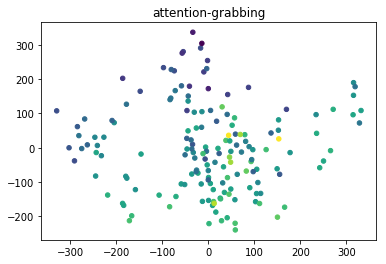

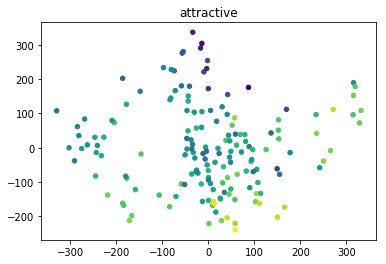

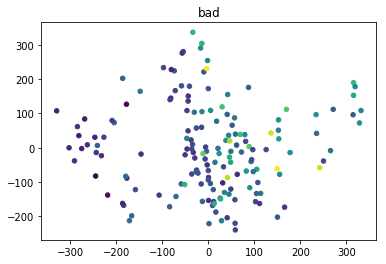

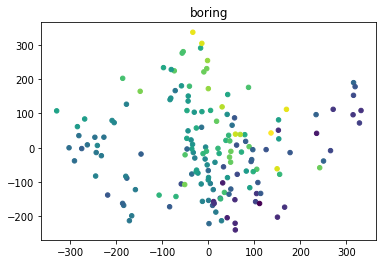

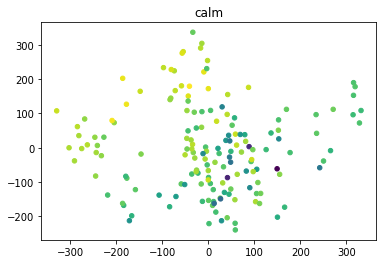

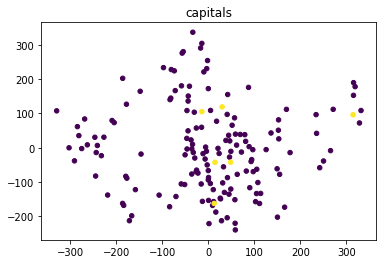

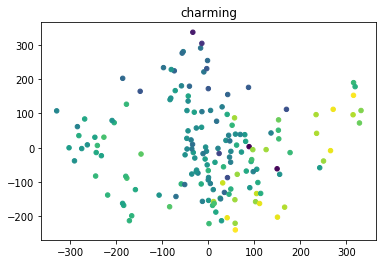

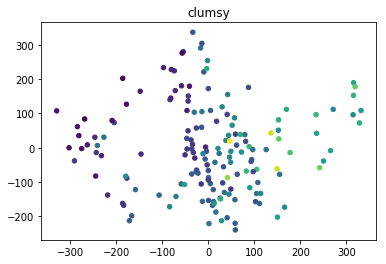

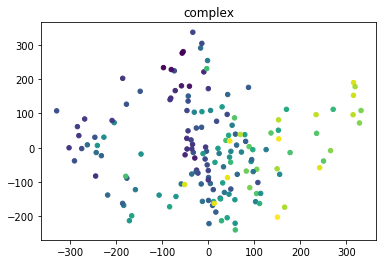

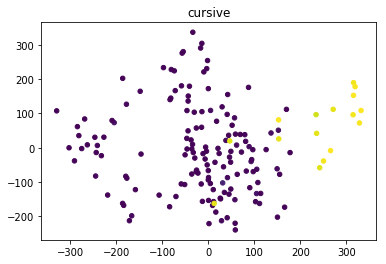

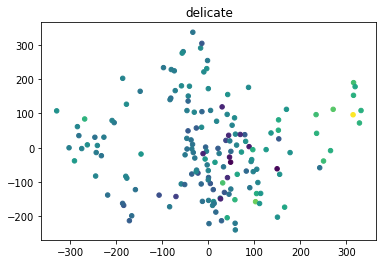

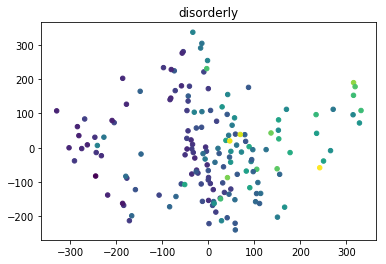

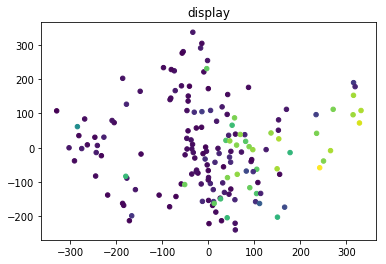

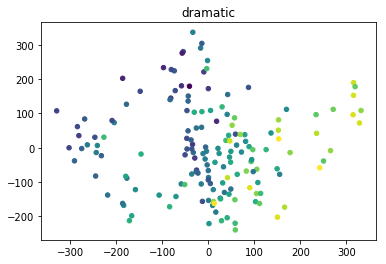

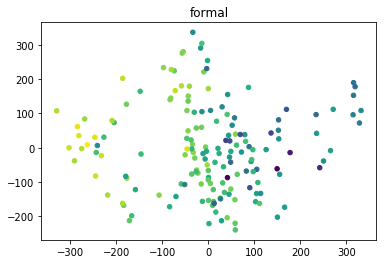

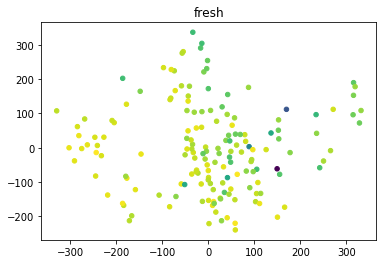

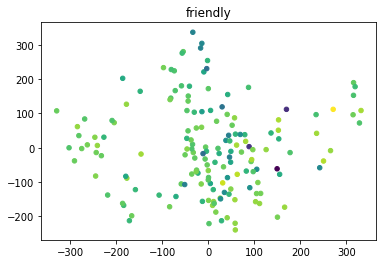

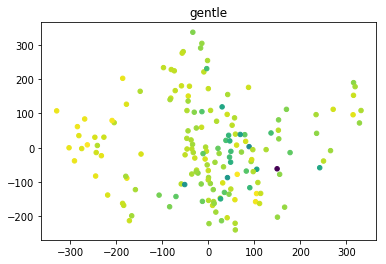

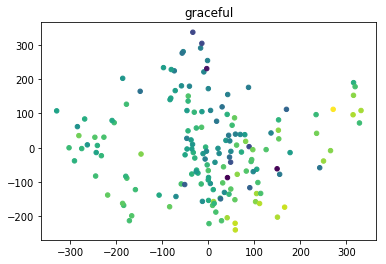

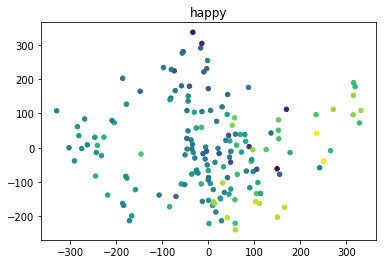

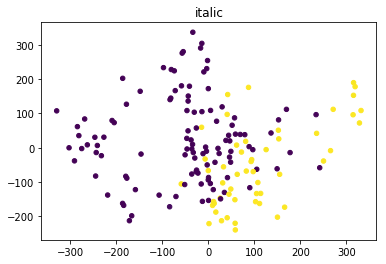

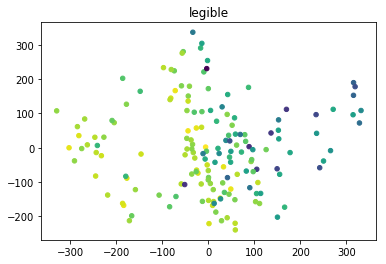

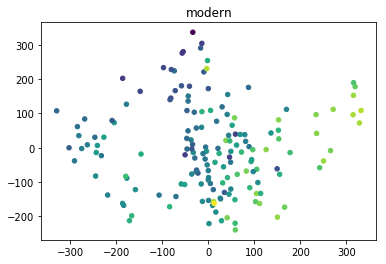

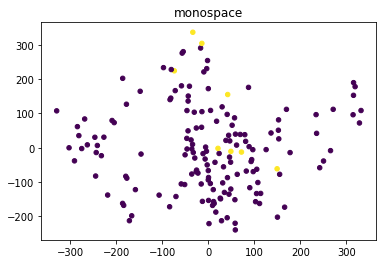

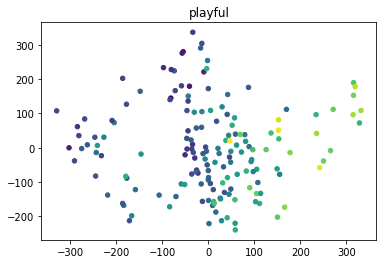

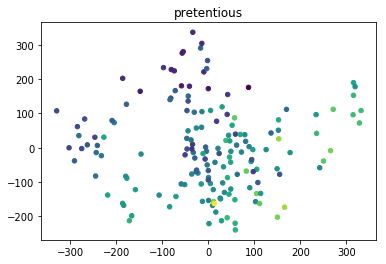

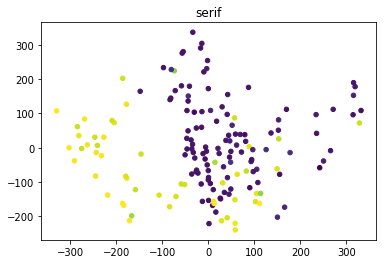

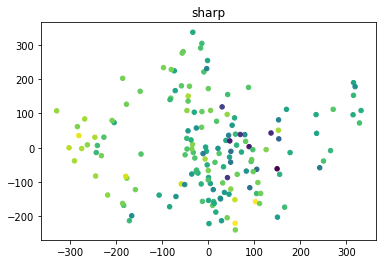

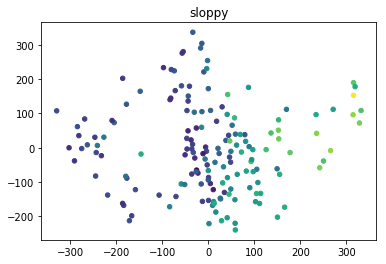

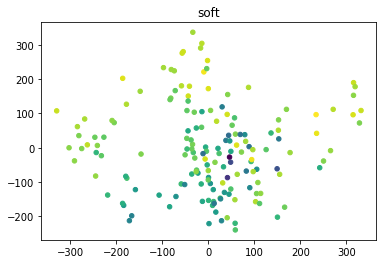

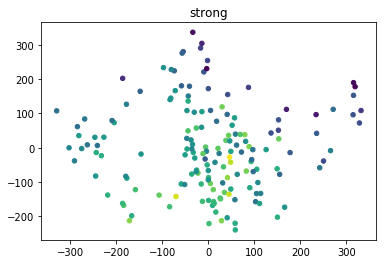

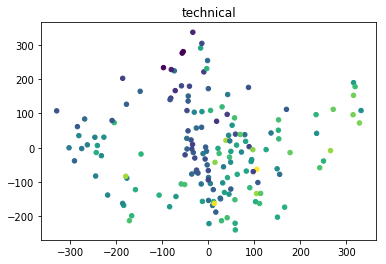

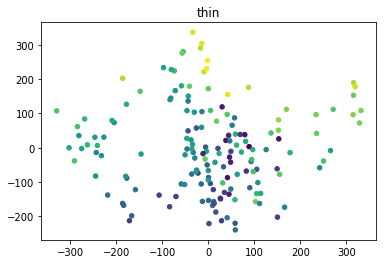

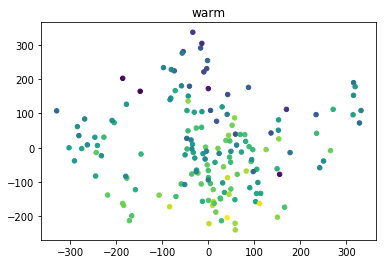

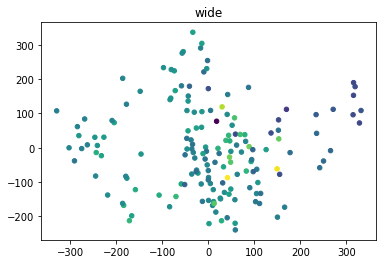

In [255]:
visualize_svm(hyper_params)

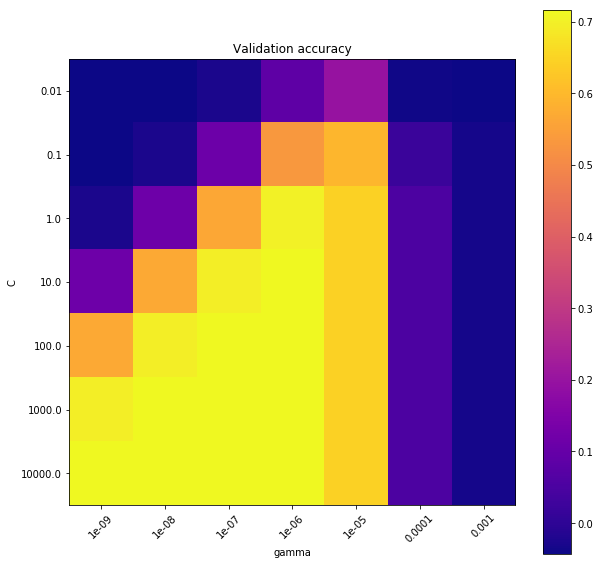

In [283]:
C_range = np.logspace(-2, 4, 7)
gamma_range = np.logspace(-9, -3, 7)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv=cv)

i = 0
grid.fit(X, y.iloc[:, i])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(10, 10))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.plasma)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()